# HyWaves metamodel: Parametrized TCs dataset 

This is a very simplified example of HyWaves toolbox. 

A specific set of synthetic and historical tropical cyclones has been selected. Selection has been done by using a 4º circle centered in a point chosed for the demonstration.

Historical cyclones have been obtained from ibtracs-wmo database and synthetic cyclones from Nakajo database (Nakajo et al 2014).

These cyclones have been parametrized according to the next 4 parameteres (sketch attached)
 - Pmin: minimum central pressure along the storm track within the circumference
 - Vmean: mean translational speed
 - Delta: azimuth of the track entrance point into the circumference
 - Gamma: angle of entry into the circumference
 

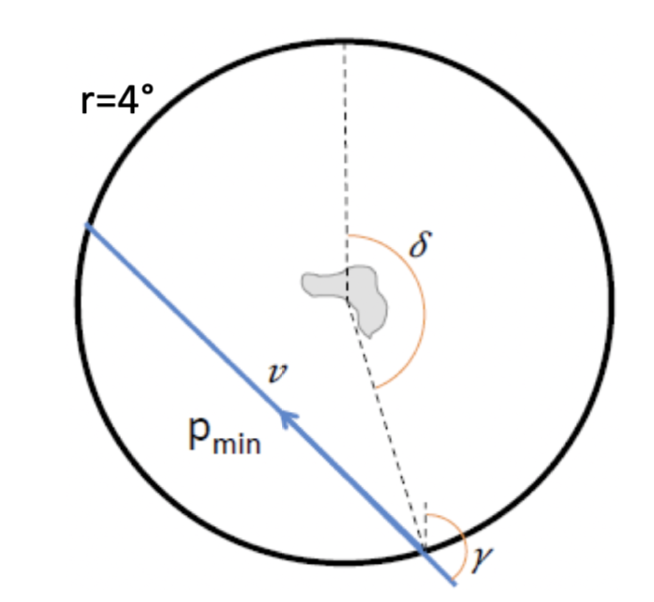

These parametrized cyclones extensive dataset (>10500 cyclones) is used as input for this notebook demonstration.

A statistical-numerical metamodel will be use to chose the cyclones to solve with SWAN numerical model in order to reduce computational efforts. Afterwards RBF interpolation methodology will be used to statistically solve the entire cyclones dataset.

A Vortex winds model will be used to generate wind fields needed to feed SWAN-NON-STATIONARY cases.

SWAN scenario is a demo case based on Roi-namur (Kwajalein atoll).


## Table of Contents

* [1. Database](#db)
* [2. Maximum Dissimilarity Algorithm (MDA) classification](#mda)
* [3. SWAN project](#sp)
    * [3.1 SWAN main mesh](#sp-mm)
    * [3.2 SWAN nested mesh](#sp-nm)
    * [3.3 SWAN case parameters](#sp-params)
    * [3.4 SWAN input: storm track, no waves](#sp-input) 
* [4. Plot site configuration](#plot-site)
* [5. SWAN WRAP](#sw)
    * [5.1 Build cases](#sw-bc)
        * [Plot input: Cyclone tracks](#plot-tracks)
        * [Plot input: Grafiti maximum winds](#plot-grafiti)
    * [5.2 Run cases](#sw-rc)
        * [Plot output: Grafiti maximum Hsig](#plot-grafiti-hs)
        * [Plot output: Control Point time series](#plot-timeseries)
    * [5.3 Extract output](#eo)
* [6. Radial Basis Functions reconstruction](#rbf)


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings('ignore')

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# statistics
from hywaves.statistical.mda import MaxDiss_Simplified_NoThreshold
from hywaves.statistical.rbf import RBF_Reconstruction, RBF_Validation

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from hywaves.swan.storms import track_site_parameters

# plotting
from hywaves.swan.plots.nonstationary import plot_project_site, plot_matrix_input, \
plot_case_output_points, plot_matrix_grafiti


## 1. Database <a name="db"></a>


In [2]:
# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', '..', 'data'))
p_demo = op.join(p_data, 'demo', 'kwa')

# load shoreline
np_shore = np.load(op.join(p_demo, 'shore_kwa.npy'))

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_demo, 'depth_kwa.nc'))

# load parametrized cyclones dataset
dataset =  pd.read_pickle(op.join(p_demo, 'dataset_r2_Kwajalein.pkl'))
dataset


,pmin,vmean,delta,gamma
0,966.13227,21.401431,69.287696,102.448480
1,999.43855,17.195274,136.127151,126.228348
2,986.18353,90.212089,71.836125,101.082872
3,975.56131,13.598327,113.340031,86.019836
4,928.46251,19.837772,79.853051,91.641105
...,...,...,...,...
10536,998.00000,14.297172,58.389517,94.829072
10537,998.00000,32.889247,107.168257,97.506173
10538,992.00000,21.404462,121.312331,103.820643
10539,992.00000,17.379389,94.069537,112.261549


## 2. Maximum Dissimilarity Algorithm (MDA) classification <a name="mda"></a>


In [3]:
n_subset = 500

data_mda = dataset.values
ix_scalar = [0, 1]       # (pmin, vmean)
ix_directional = [2, 3]  # (delta, gamma)

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
        data_mda, n_subset, ix_scalar, ix_directional)

# subset dataframe
subset = pd.DataFrame({
    'pmin': centroids[:,0],
    'vmean': centroids[:,1],   # (km/h) ( /1.852  # [km/h] -> [kt])
    'delta': centroids[:,2],
    'gamma': centroids[:,3],
})
subset

# subset TCs parameters
pmin = subset['pmin'].values
vmean = subset['vmean'].values
delta = subset['delta'].values
gamma = subset['gamma'].values



MaxDiss waves parameters: 10541 --> 500

   MDA centroids: 500/500



## 3. SWAN project <a name="sp"></a>


In [4]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_03_demo'                 # project name

sp = SwanProject(p_proj, n_proj)

# some optional data (will be used at plotting)
sp.shore = np_shore  # project shoreline


### 3.1 SWAN main mesh <a name="sp-mm"></a>


In [5]:
# get variables from bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]
depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value (from file)
main_mesh.depth = depth

# computational grid description
res = 0.136  # (15km = 0.136º)  
main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),

}

sp.set_main_mesh(main_mesh)


### 3.2 SWAN nested mesh (optional) <a name="sp-nm"></a>


In [6]:
# lets cut inputh depth to a smaller area
xds_bathy_nest = xds_bathy.sel(
    lon = slice(165, 170),
    lat = slice(7, 10),
)

# get variables from bathymetry 
lon = xds_bathy_nest.lon.values[:]
lat = xds_bathy_nest.lat.values[:]
depth = xds_bathy_nest.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
mesh_nest = SwanMesh()

# depth grid description (input bathymetry grid)
mesh_nest.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
mesh_nest.dg_idla = 3

# depth value (from file)
mesh_nest.depth = depth

# computational grid description
res_nest = 0.04545

mesh_nest.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res_nest),
    'myc': int((lat[-1]-lat[0])/res_nest),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res_nest),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res_nest),

}

# set project nested mesh list
sp.set_nested_mesh_list([mesh_nest])


### 3.3 SWAN case parameters <a name="sp-params"></a>


In [7]:
input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '20 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '20 MIN',
    
    'output_deltt': '30 MIN',
    
    'output_points_x': [167.7336],
    'output_points_y': [8.66686],

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ]
}
sp.set_params(input_params)


### 3.4 SWAN input: storm track, no waves <a name="sp-input"></a>


In [8]:
# target coordinates
target = 'Kwajalein'
x0, y0 = 167.73, 8.72

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]

# generate interpolated storms track list (within the target area)
r2 = 4      # radii from TC parameters 
date_ini = '2020-01-01 00:00'
st_list, we_list = [], []

for (pm, vm, de, ga) in zip(pmin, vmean, delta, gamma):

    # computational time step [min] following Vmean criteria: 
    if vm < 20:      dt_comp = 20  # if vmean < 20km/h  dt_comp=20'
    elif vm >= 20:   dt_comp = 10  # if vmean > 20km/h  dt_comp=10'

    st = track_site_parameters(
        dt_comp, pm, vm/1.852, de, ga, x0, y0, 
        lon[0], lon[-1], lat[0], lat[-1], r2, date_ini
    )

    # [OPTIONAL] override SWAN storm case computational delta time (compute_deltc) parameter
    st.attrs['override_dtcomp'] = '{0} MIN'.format(dt_comp)

    # time array for SWAN case input
    time = pd.date_range(date_ini, periods=st.shape[0], freq='{0}min'.format(dt_comp))

    # generate empty wave event
    we = pd.DataFrame(index=time, columns=['hs', 't02', 'dir', 'spr', 'U10', 'V10'])
    we['level'] = 0
    we['tide'] = 0

    st_list.append(st)
    we_list.append(we)   


## 4. Plot site configuration <a name="plot-site"></a>


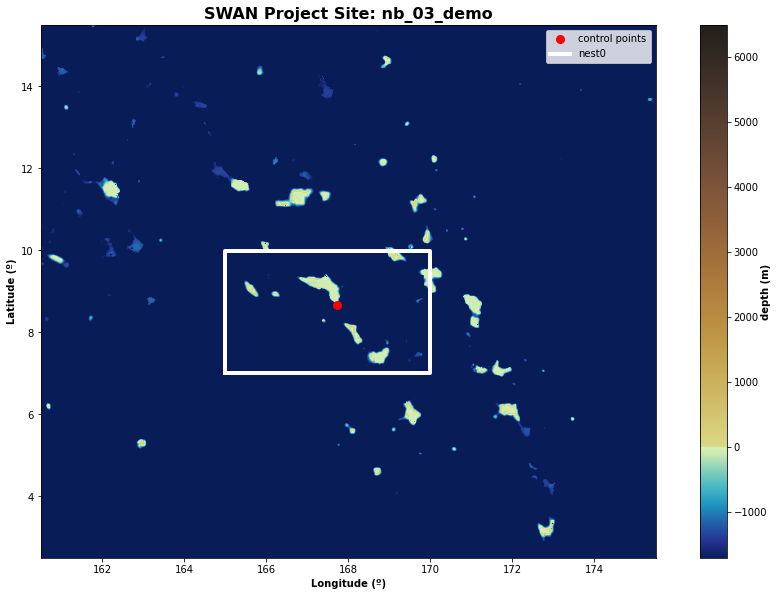

In [9]:
# plot site depth, control points, nested meshes (if any)
plot_project_site(sp);


## 5. SWAN WRAP <a name="sw"></a>


In [10]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)


### 5.1 Build cases <a name="sw-bc"></a>

Only 9 cases will be built and executed inside this demonstration notebook as the entire subset (500 cases) will require high computational time.


In [11]:
# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases(we_list, storm_track_list=st_list[0:9], make_waves=False, make_levels=False)


CASE 0000 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0001 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0002 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0003 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0004 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0005 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0006 - compute_deltc, wind_deltinp override with storm track: 10 MIN
CASE 0007 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0008 - compute_deltc, wind_deltinp override with storm track: 20 MIN


### Plot input: Cyclone tracks <a name="plot-tracks"></a>


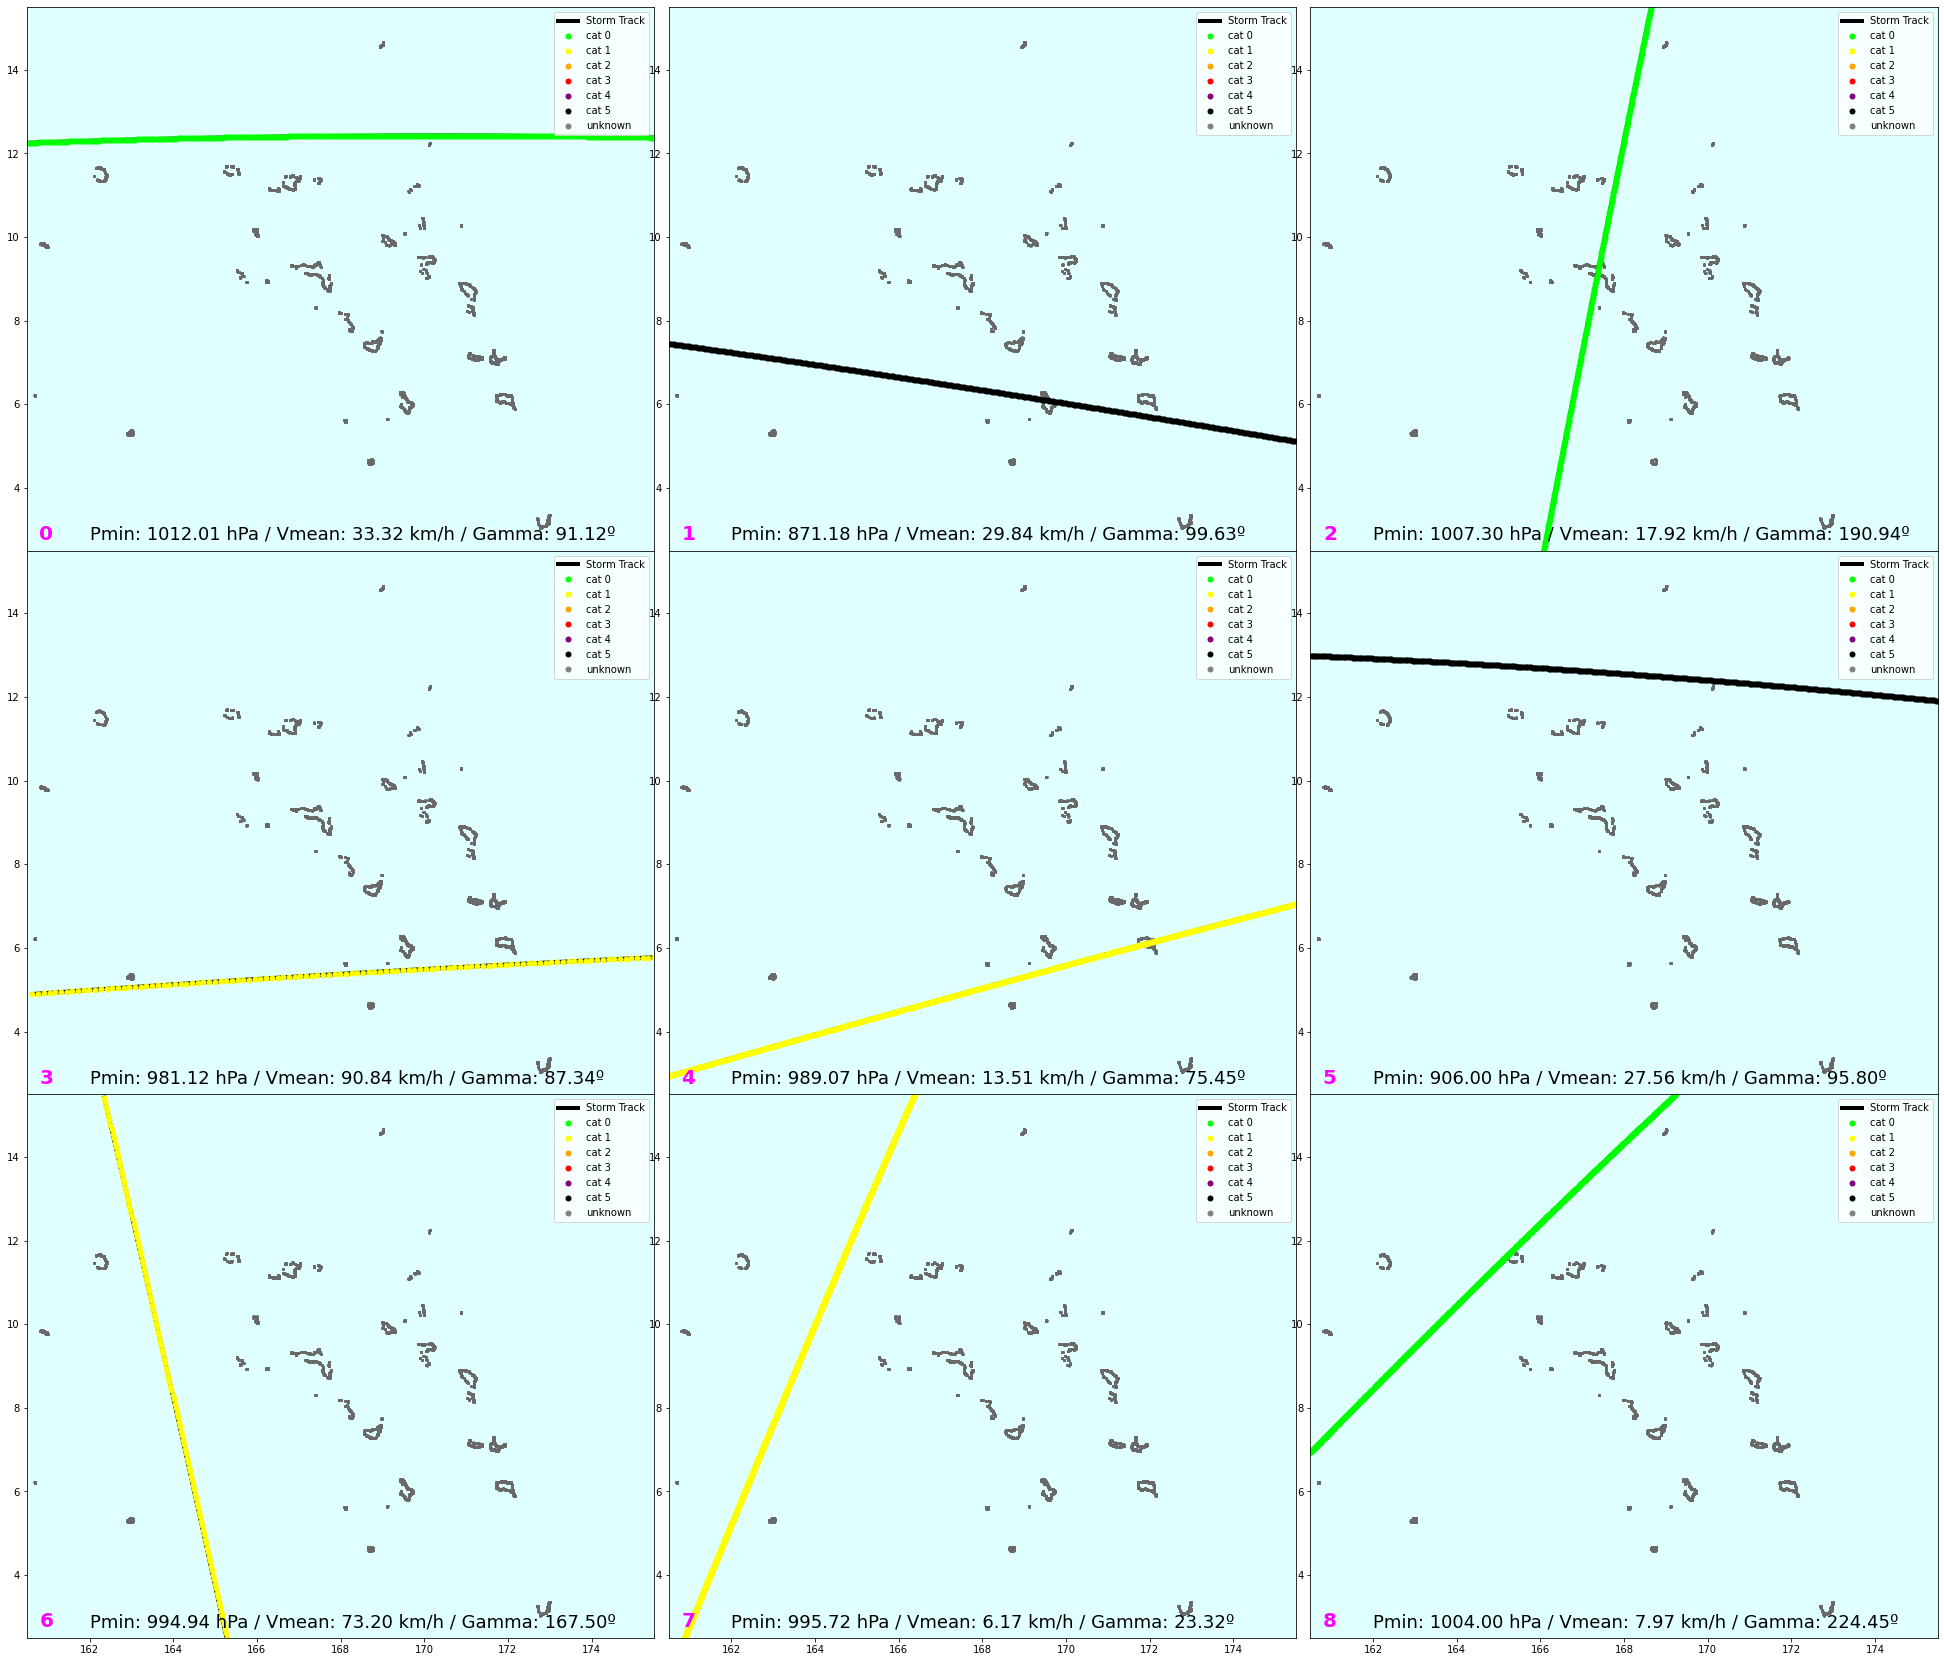

In [12]:
plot_matrix_input(sp, storm_track_list=st_list, case_ini=0, case_end=9);


### Plot input: Grafiti maximum winds <a name="plot-grafiti"></a>


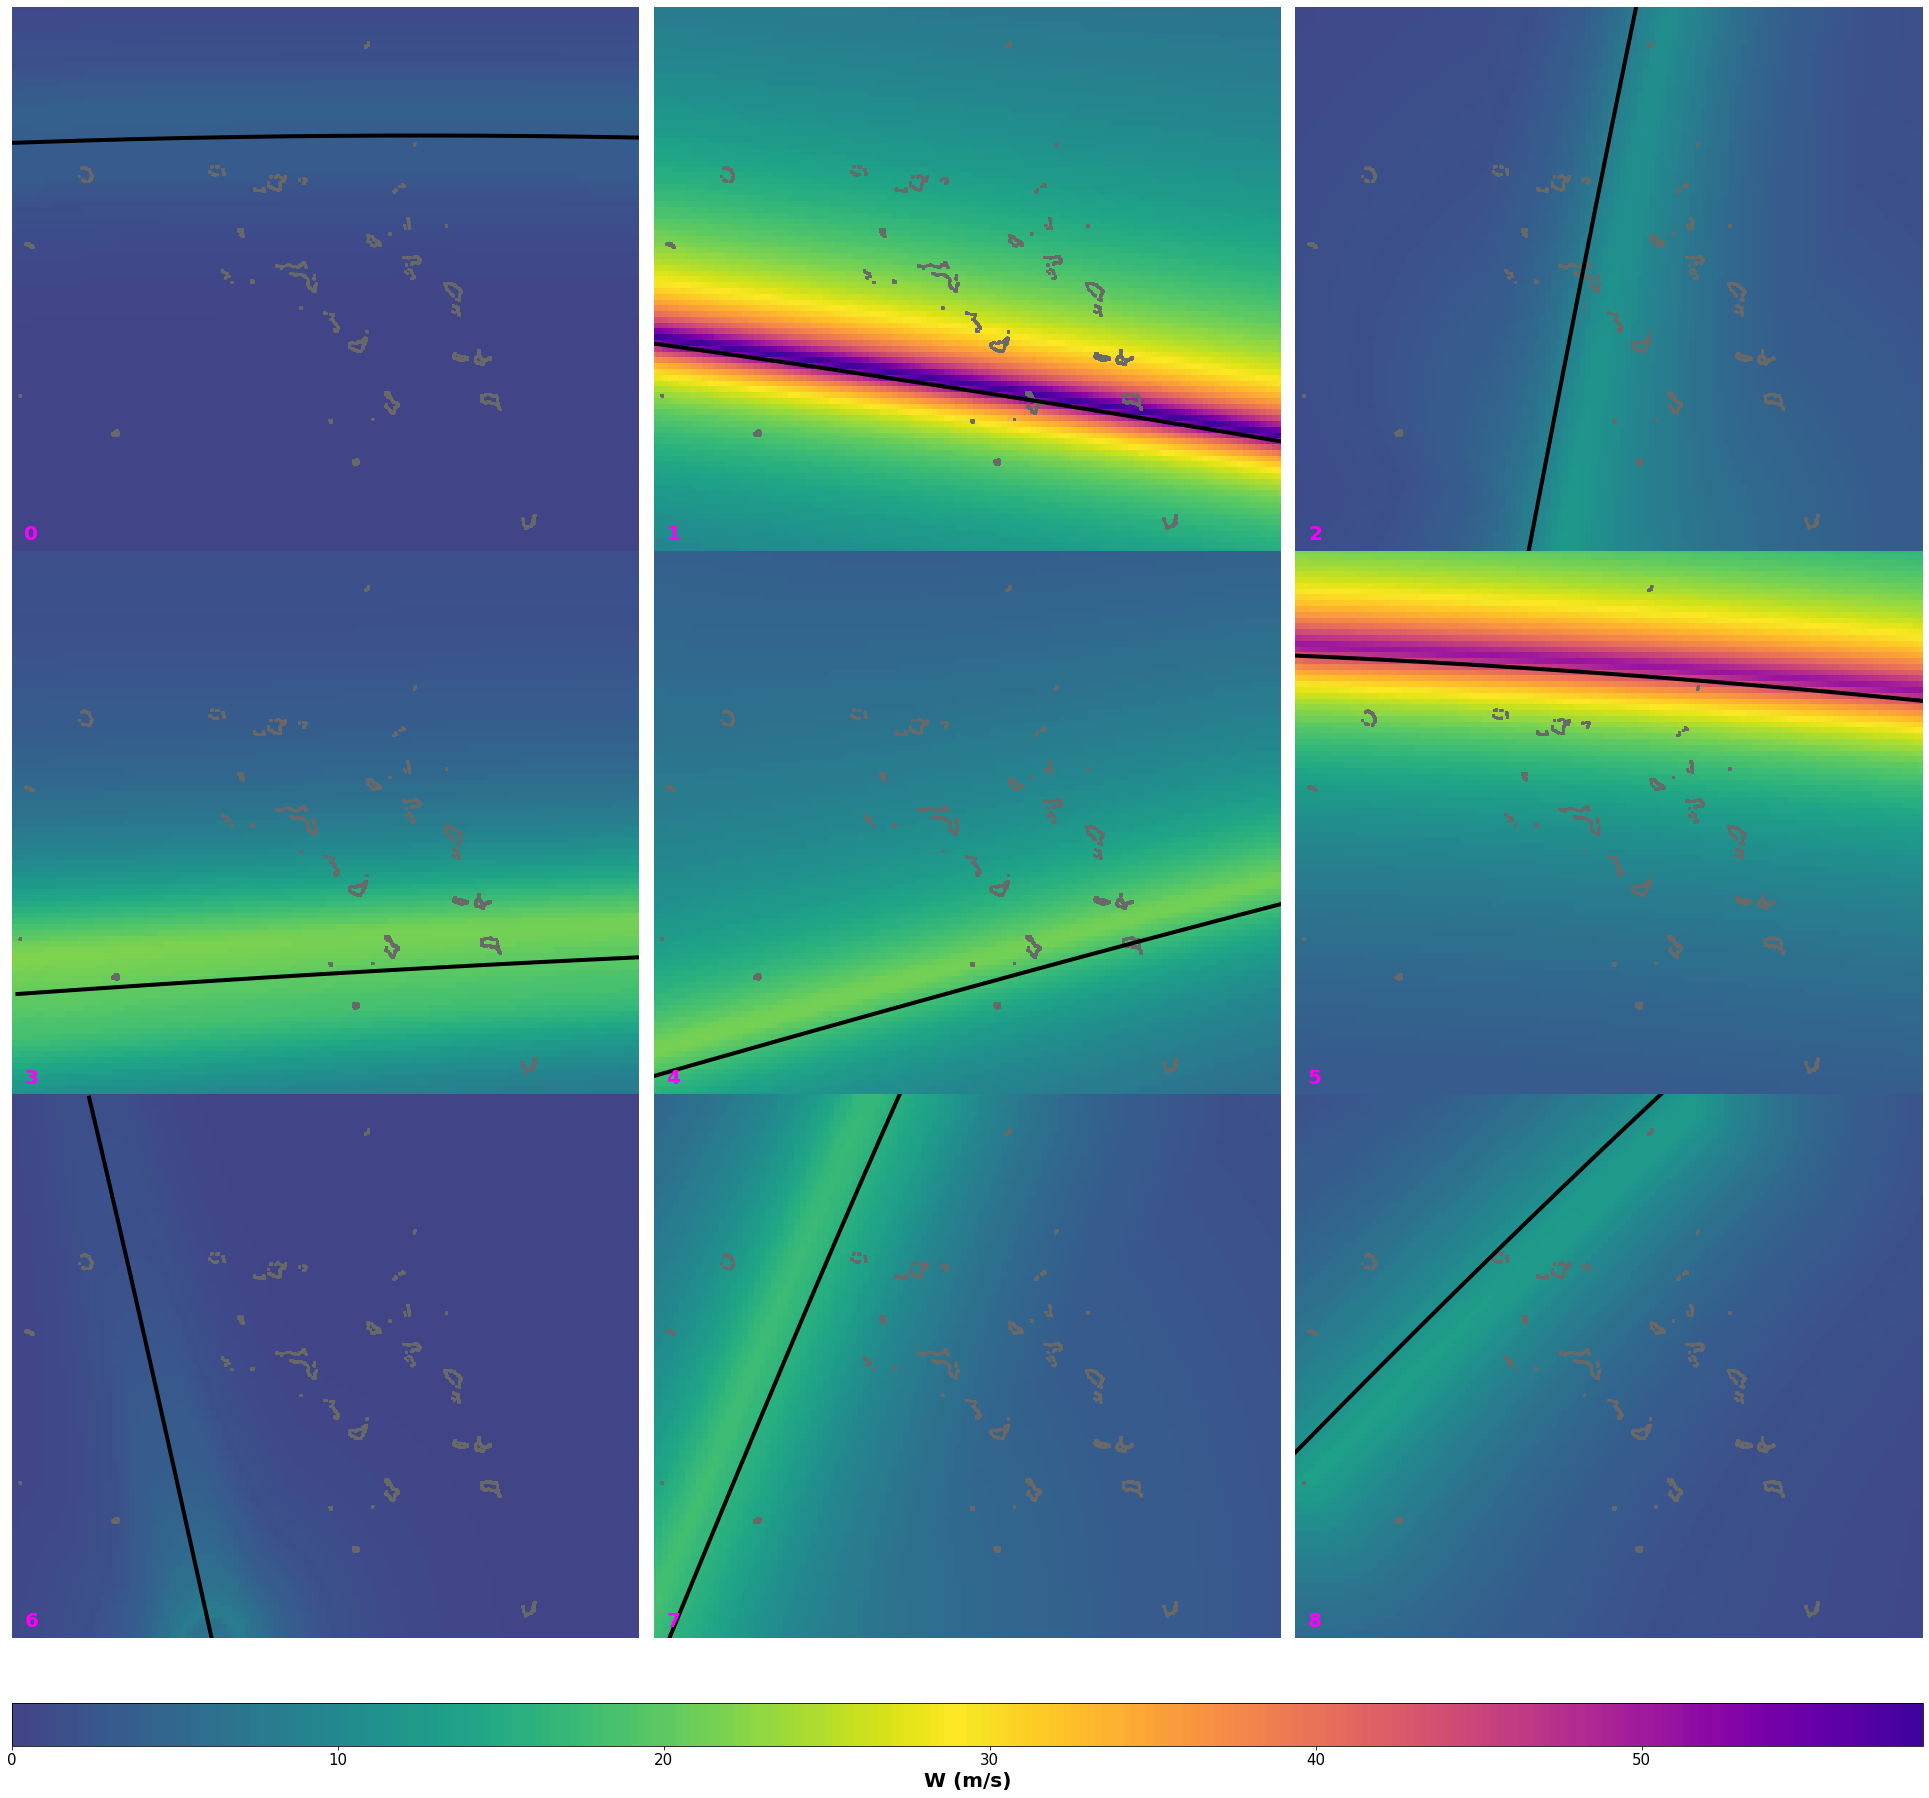

In [13]:
plot_matrix_grafiti(sw, 'W', storm_track_list=st_list, case_ini=0, case_end=9);


### 5.2 Run cases <a name="sw-rc"></a>


In [14]:
sw.run_cases()


SWAN CASE: 0000 SOLVED
SWAN CASE: 0001 SOLVED
SWAN CASE: 0002 SOLVED
SWAN CASE: 0003 SOLVED
SWAN CASE: 0004 SOLVED
SWAN CASE: 0005 SOLVED
SWAN CASE: 0006 SOLVED
SWAN CASE: 0007 SOLVED
SWAN CASE: 0008 SOLVED


### Plot output: Grafiti maximum Hsig <a name="plot-grafiti-hs"></a>


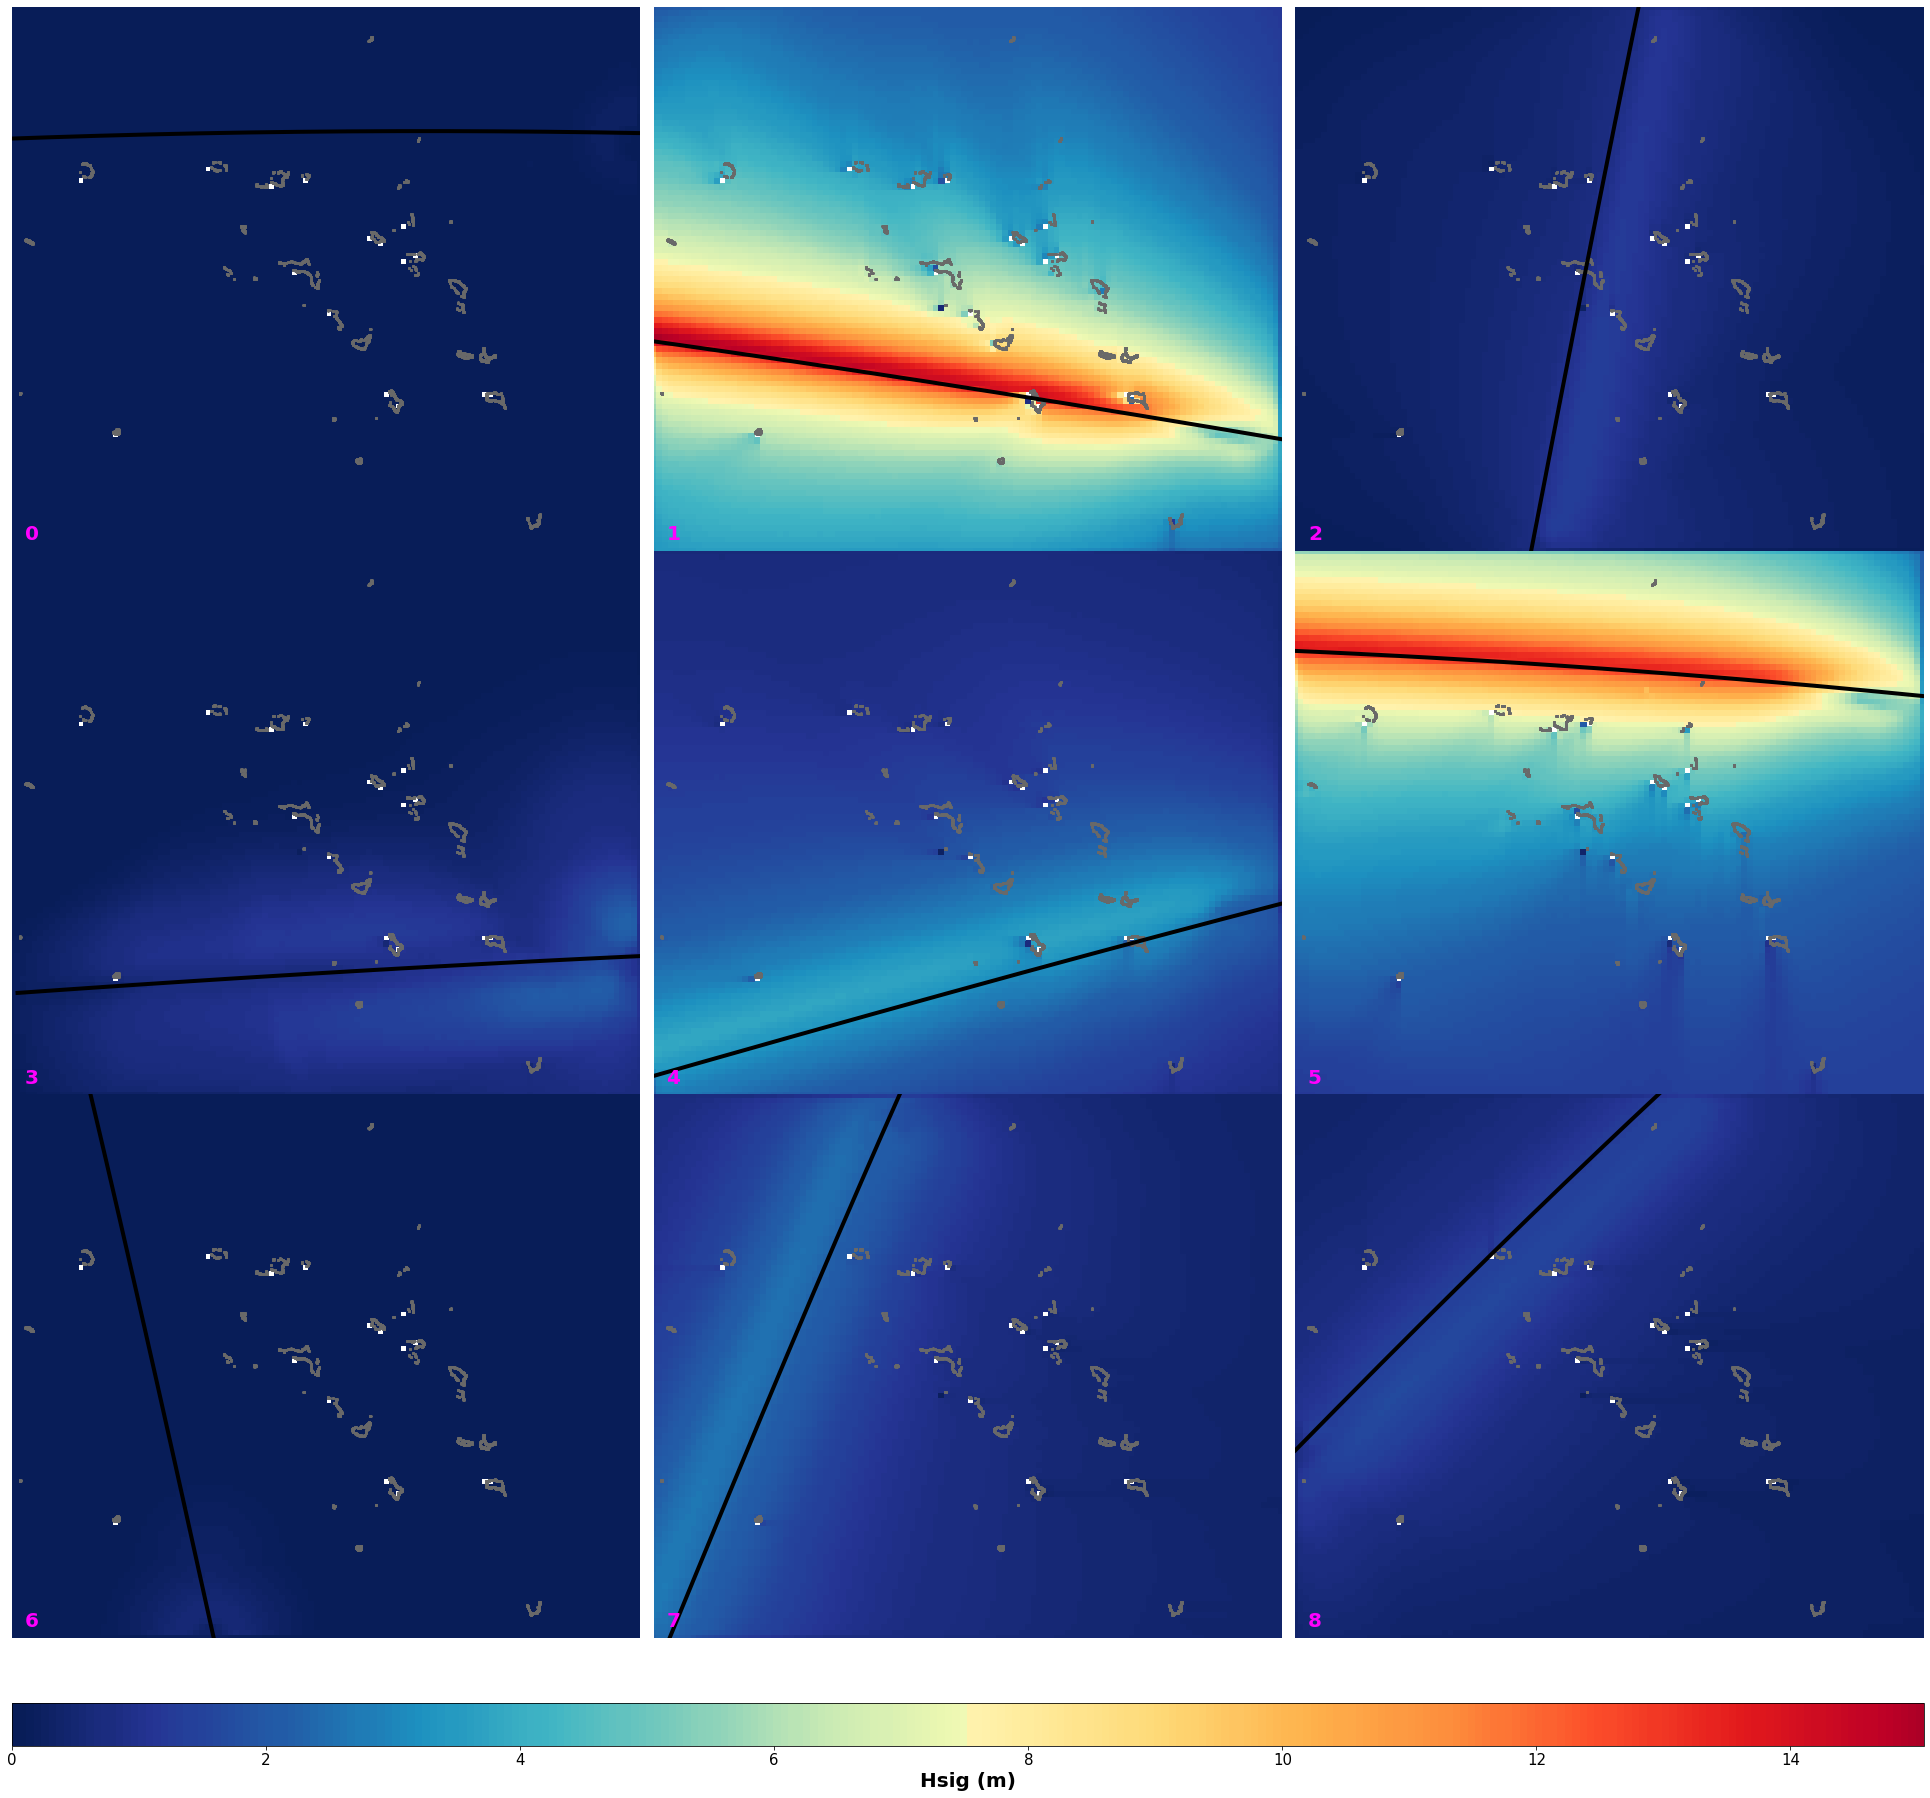

In [15]:
plot_matrix_grafiti(sw, 'Hsig', storm_track_list=st_list, case_ini=0, case_end=9);


### Plot output: Control Point time series <a name="plot-timeseries"></a>


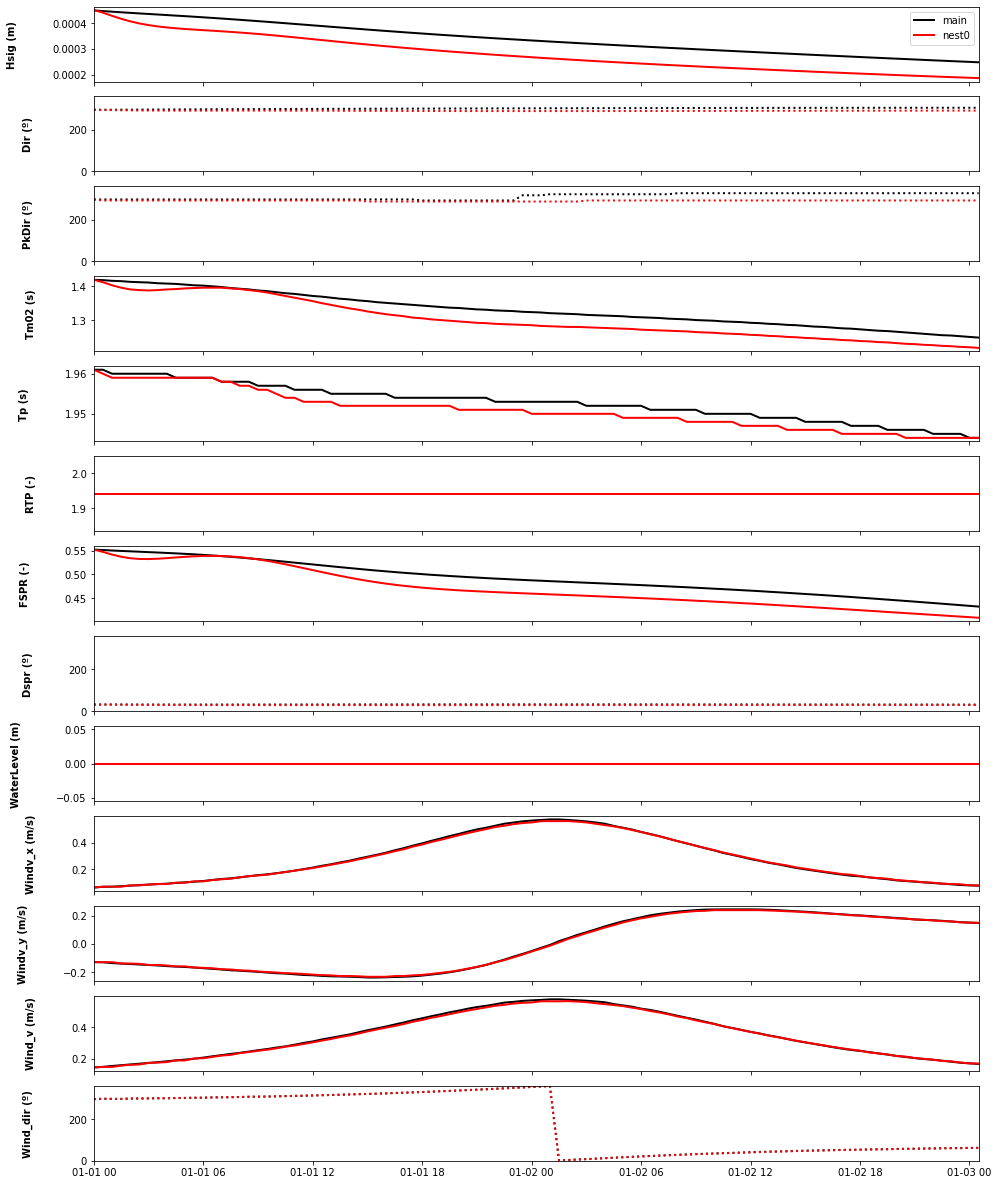

In [16]:
plot_case_output_points(sw, case=0);


### 5.3 Extract output <a name="eo"></a>


####  **Mesh main**

In [17]:
output_main = sw.extract_output(case_ini=0, case_end=9)
print(output_main)


[<xarray.Dataset>
Dimensions:     (lat: 95, lon: 110, time: 98)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-01-03T00:30:00
  * lon         (lon) float64 160.5 160.6 160.8 160.9 ... 175.1 175.2 175.4
  * lat         (lat) float64 2.502 2.639 2.776 2.912 ... 15.09 15.22 15.36
Data variables:
    PkDir       (time, lat, lon) float32 nan nan nan nan ... 182.5 187.5 192.5
    Dspr        (time, lat, lon) float32 nan nan nan ... 16.524696 15.427485
    Hsig        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.05558818 0.054470684
    WaterLevel  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Dir         (time, lat, lon) float32 nan nan nan ... 197.08014 201.03287
    Tp          (time, lat, lon) float32 nan nan nan ... 2.4682262 2.4817004
    RTpeak      (time, lat, lon) float32 nan nan nan ... 2.5798135 2.5798135
    FSpr        (time, lat, lon) float32 nan nan nan ... 0.60939676 0.61588883
    Depth       (time, lat, lon) float32 3429.0 3490.05

####  **Mesh nested**

In [18]:
output_nest = sw.extract_output(case_ini=0, case_end=9, mesh=mesh_nest)
print(output_nest)


[<xarray.Dataset>
Dimensions:     (lat: 65, lon: 109, time: 98)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-01-03T00:30:00
  * lon         (lon) float64 165.0 165.0 165.1 165.1 ... 169.9 169.9 170.0
  * lat         (lat) float64 7.002 7.048 7.094 7.14 ... 9.814 9.86 9.906 9.952
Data variables:
    PkDir       (time, lat, lon) float32 297.5 297.5 297.5 ... 307.49997 67.5
    Dspr        (time, lat, lon) float32 31.505903 31.505896 ... 48.725277
    Hsig        (time, lat, lon) float32 0.00014027423 ... 0.00067765824
    WaterLevel  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Dir         (time, lat, lon) float32 299.744 299.744 ... 317.8977 320.4065
    Tp          (time, lat, lon) float32 1.9607 1.9606998 ... 1.9389904
    RTpeak      (time, lat, lon) float32 1.9413847 1.9413847 ... 1.9413847
    FSpr        (time, lat, lon) float32 0.54873294 0.54873294 ... 0.3141068
    Depth       (time, lat, lon) float32 5152.0 5166.778 ... 4227.66

####  **Points (mesh main)**

In [19]:
output_pts = sw.extract_output_points(case_ini=0, case_end=9)
print(output_pts, '\n')


<xarray.Dataset>
Dimensions:     (case: 9, point: 1, time: 506)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-01-11T12:30:00
  * case        (case) int64 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: point
Data variables:
    Hsig        (case, point, time) float64 0.0004487 0.0004462 ... nan nan
    Dir         (case, point, time) float64 296.2 296.3 296.5 ... nan nan nan
    PkDir       (case, point, time) float64 297.5 297.5 297.5 ... nan nan nan
    Tm02        (case, point, time) float64 1.418 1.417 1.415 ... nan nan nan
    Tp          (case, point, time) float64 1.961 1.961 1.96 ... nan nan nan
    RTP         (case, point, time) float64 1.941 1.941 1.941 ... nan nan nan
    FSPR        (case, point, time) float64 0.5521 0.5512 0.5502 ... nan nan nan
    Dspr        (case, point, time) float64 31.52 31.52 31.52 ... nan nan nan
    DEPTH       (case, point, time) float64 2.764e+03 2.764e+03 ... nan nan
    WaterLevel  (case, point, time) float64 0.0 0

## 6. Radial Basis Functions Reconstruction <a name="rbf"></a>

Selected parametrized cyclones subset has been solved using SWAN NON STATIONARY numerical model, now output waves conditions at the study point are extracted for this subset. From the output we will use only maximun values for Hs and Tp variables.

This subset input - output combination will be used to statistically reconstruct the maximun Hs and Tp values for the entire dataset. Reconstruction will be done using RBFs interpolation.


<div class="alert alert-block alert-warning">
    
<b>NOTE:</b> This notebook is a demonstration for the purpose of training and only a reduced subset of 9 cases has been numerically solved. This small quantity of solved cases won't be enought to obtain a good RBF interpolation output.

In [20]:
# Prepare our dataset, subset, and target for RBFs reconstruction

subset_rbf = subset.iloc[0:9]  # NOTE: for this demonstration only 9 subset cases have been numercally solved
dataset_rbf = dataset

# Extract output waves at study point (nested mesh)
out_points = sw.extract_output_points(mesh=mesh_nest)

# Get maximun Hs and Tp for each case (RBFs target)
target_rbf = out_points.max(dim='time').squeeze()[['Hsig', 'Tp']].to_dataframe()

# select dataset and subset variables
vns_ds = ['pmin', 'vmean', 'delta', 'gamma']

# select target variables
vns_tgt = ['Hsig', 'Tp']

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]       # scalar (pmin, vmean)
ix_directional_subset = [2,3]  # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1]       # scalar (Hsig, Tps)
ix_directional_target = []     # directional


In [21]:
# Obtain Hsig and Tp max values for the entire dataset using RBF reconstruction 
recon = RBF_Reconstruction(
    subset_rbf[vns_ds].values, ix_scalar_subset, ix_directional_subset,
    target_rbf[vns_tgt].values, ix_scalar_target, ix_directional_target,
    dataset_rbf[vns_ds].values,
)

# mount reconstruction as pandas.DataFrame
recon = pd.DataFrame(data=recon, columns=vns_tgt, index=dataset.index)

print(recon)


ix_scalar: 0,  optimization: 0.02 | interpolation: 0.44, sigma_opt: 0.70
ix_scalar: 1,  optimization: 0.03 | interpolation: 0.48, sigma_opt: 0.10
           Hsig         Tp
0      1.925128   8.693203
1      1.392255   6.215211
2     -0.074777   2.123510
3      2.319810   8.470712
4      3.369720  11.843493
...         ...        ...
10536  0.965664   6.657403
10537  1.058147   5.266246
10538  1.625762   6.554240
10539  1.473120   6.861234
10540  0.459543   5.497725

[10541 rows x 2 columns]
